In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
!unzip gdrive/MyDrive/mydata.zip

In [ ]:
%pip install captcha 
%pip install opencv-python --user
!apt update && apt install -y libsm6 libxext6 --user
!pip install opencv-python-headless --user
!pip install opencv-contrib-python-headless --user
%pip install keras --user

In [4]:
import argparse
import json
import string
import os
import shutil
import uuid
from captcha.image import ImageCaptcha

import itertools

import cv2
import numpy as np
from random import random, randint, choices

import pandas as pd
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, Input
import matplotlib.pyplot as plt

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import resnet18

import string
from tqdm.notebook import tqdm
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import multiprocessing as mp

In [ ]:
alphabet_all = list('qwertyupasdfghjkzxcvbnm23456789QWERTYUPKJHGFDSAZXCVBNM')
alphabet = list('qwertyupasdfghjkzxcvbnm23456789')#QWERTYUIOPLKJHGFDSAZXCVBNM')
num_alphabet = len(alphabet)
def _gen_captcha(img_dir, num_of_letters, num_of_repetition, width, height):
    if os.path.exists(img_dir):
        shutil.rmtree(img_dir)
    if not os.path.exists(img_dir):
        os.makedirs(img_dir)

    image = ImageCaptcha(width=width, height=height)

    for counter in range(num_of_repetition):
        i = choices(alphabet_all, k=5)
        captcha = ''.join(i)
        fn = os.path.join(img_dir, '%s_%s.png' % (captcha, uuid.uuid4()))
        image.write(captcha, fn)


def gen_dataset(path, num_of_repetition, num_of_letters, width, height):
    _gen_captcha(os.path.join(path, 'data'), num_of_letters, num_of_repetition, width, height)
    print('Finished Data Generation')

In [5]:
BATCH_SIZE = 16
NUM_OF_LETTERS = 5
EPOCHS = 50
IMG_ROW, IMG_COLS = 50, 135

# Non-configs
PATH = os.getcwd()
DATA_PATH = os.path.join(PATH, 'train') # if it's on colab, then the path will be DATA_PATH.
#DATA_PATH = "C:\\Users\\Victor\\Desktop" # this path is on my local environment where the image captchas are located

In [ ]:
# generate captcha 
if not os.path.exists(DATA_PATH):
    print('Generating Dataset')
    gen_dataset(DATA_PATH, 100*1000 , NUM_OF_LETTERS, IMG_COLS, IMG_ROW)

In [17]:
# use 100000 images with 80/20 split
real_path = DATA_PATH # here please adjust the path/directory of the data!
#real_path = real_path.replace('\\','/') 
image_names = os.listdir(real_path) # load file names for all image captchas
# Below I used 5000 images for the progress report, which took me more than 2 hours to complete it.
# to check if the code works and save time, please use a small sample size (e.g. 200 images)
image_names_train, image_names_test = train_test_split(image_names[0:5000], test_size = 0.2, train_size = 0.8, random_state=0, shuffle=True)
print(len(image_names_train), len(image_names_test))

4000 1000


In [ ]:
image_text = [image_name.split("_")[0] for image_name in image_names]
image_text = "".join(image_text)
letters = sorted(list(set(list(image_text))))
#print(letters)
vocabulary = ["-"] + letters # for indexing and CTC loss ---> adding "-" is necessary!
#print(len(vocabulary))
#print(vocabulary)
idx_to_char = {k:v for k,v in enumerate(vocabulary, start=0)}
print(idx_to_char)
char_to_idx = {v:k for k,v in idx_to_char.items()}
print(char_to_idx)
num_chars = len(char_to_idx) # the number of classes/features
print(num_chars)

In [11]:
class load_captcha(Dataset):
    
    def __init__(self, real_path, image_names):
        self.data_dir = real_path
        self.image_names = image_names
        
    def __len__(self):
        return len(self.image_names)
    
    def __getitem__(self, index):
        image_name = self.image_names[index]
        real_path = self.data_dir + '/' + image_name
        image_path = real_path.replace('\\','/')  # please replace this line with your own path!
        image = Image.open(image_path).convert('RGB')
        image = self.transform(image)
        text = image_name.split("_")[0] # return the 5-letter captcha (string)
        return image, text
    
    def transform(self, image):
        transform_ops = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
        ])
        return transform_ops(image)

In [ ]:
# check the size of one image output & debug
my_input = image_names_train[0:1]
my_train=load_captcha(real_path, my_input) 
#print(DataLoader(my_train))
my_train_loader = DataLoader(my_train, shuffle=True)
my_output=my_train.__getitem__(0)[0]
print(my_output)

In [18]:
batch_size = 16
# data loader using pytorch
trainset = load_captcha(real_path, image_names_train) 
testset = load_captcha(real_path, image_names_test)
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False)
print(len(train_loader), len(test_loader))

250 63


In [ ]:
# get loaded data with a defined batch size using iter().next()
image_train, text_train = iter(train_loader).next()
image_test, text_test = iter(test_loader).next()
print(image_train.size(), text_train, image_test.size(), text_test)

In [ ]:
resnet = resnet18(pretrained=True)
#list(resnet.children())

In [8]:
# CRNN model based on https://github.com/abhishekkrthakur/captcha-recognition-pytorch/blob/master/model.py ,
# https://actamachina.com/notebooks/2019/03/28/captcha.html ,
# https://github.com/shishishu/pytorch-captcha-recognition ,
# https://github.com/GokulKarthik/Deep-Learning-Projects.pytorch/blob/master/5-Captcha-Text-Recognition-With-CRNN.ipynb ,
# https://www.kaggle.com/shawon10/captcha-recognition and
# https://github.com/DrMahdiRezaei/Deep-CAPTCHA/blob/master/Captcha_Solver_numerical.ipynb
class captcha_CRNN1(nn.Module):

    def __init__(self, num_chars, rnn_hidden_size=256, dropout=0.1):
        super(captcha_CRNN1, self).__init__()
        self.num_chars = num_chars
        self.rnn_hidden_size = rnn_hidden_size
        self.dropout = dropout
        
        resnet_modules = list(resnet.children())[:-3] # --> remove the last three modules (1 nn.sequential, 1 avg_pool and 1 linear)
        self.cnn1 = nn.Sequential(*resnet_modules)
        self.cnn2 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=(3,6), stride=1, padding=1),
            nn.BatchNorm2d(256), 
            nn.ReLU(inplace=True)
        )
        self.linear1 = nn.Linear(1024, 256)
        self.rnn1 = nn.GRU(input_size=rnn_hidden_size, hidden_size=rnn_hidden_size, bidirectional=True, batch_first=True)
        self.rnn2 = nn.GRU(input_size=rnn_hidden_size, hidden_size=rnn_hidden_size, bidirectional=True, batch_first=True)
        self.linear2 = nn.Linear(self.rnn_hidden_size*2, num_chars) # bidirection = T so multiply by 2
    
    def forward(self, x): # for 16 batches data
        x = self.cnn1(x) # torch.Size([16, 256, 4, 9])
        #print(x.size()) 
        x = self.cnn2(x) # torch.Size([16, 256, 4, 6]) [batch_size, channels, height, width]
        #print(x.size()) 
        x = x.permute(0, 3, 1, 2) # torch.Size([16, 6, 256, 4])  [batch_size, width, channels, height]
        #print(x.size()) 
        batch_size = x.size(0)
        T = x.size(1) # time length
        x = x.view(batch_size, T, -1) # [batch_size, T==width, num_features==channels*height]
        #print(x.size()) # torch.Size([-1, T, 1024]) ---> torch.Size([16, 6, 1024])
        x = self.linear1(x)
        #print(x.size()) # torch.Size([-1, T, 256]) ---> torch.Size([16, 6, 256])
        x, hidden = self.rnn1(x)
        feature_size = x.size(2) # torch.Size([16, 6, 256*2])
        x = x[:, :, :feature_size//2] + x[:, :, feature_size//2:] # torch.Size([16, 6, 256]) 
        #print(x.size())
        x, hidden = self.rnn2(x) # torch.Size([16, 6, 512])
        #print(x.size()) 
        x = self.linear2(x) # torch.Size([-1, T, num_features]) ---> torch.Size([16, 6, 55])
        #print(x.size()) 
        x = x.permute(1, 0, 2) # [T, batch_size, num_features] for CTC loss training
        #print(x.size()) # torch.Size([6, 16, 55]) ---> batch_size has to be in the middle!
        return x

In [9]:
# weight matrices application using https://github.com/GokulKarthik/Deep-Learning-Projects.pytorch/blob/master/5-Captcha-Text-Recognition-With-CRNN.ipynb
def weights_init(m): 
    classname = m.__class__.__name__
    if type(m) in [nn.Linear, nn.Conv2d, nn.Conv1d]:
        torch.nn.init.xavier_uniform_(m.weight) 
        if m.bias is not None:
            m.bias.data.fill_(0.01)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [ ]:
crnn = captcha_CRNN1(num_chars=num_chars,rnn_hidden_size=256)
crnn.apply(weights_init)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
crnn = crnn.to(device)
#crnn
#processed_label_train = crnn(image_train.to(device))
#print(processed_label_train)
#processed_label_train.size() # torch.Size([6, 16, 55])

In [20]:
def encode_captcha(text_captcha):
    text_lens = [len(text) for text in text_captcha]
    text_lens = torch.IntTensor(text_lens)
    text_raw = "".join(text_captcha)
    text_encoded = [char_to_idx[text] for text in text_raw]
    text_encoded = torch.IntTensor(text_encoded)
    return text_encoded, text_lens

def decode_predictions(text_encoded):
    pred_decoded = F.softmax(text_encoded, 2).argmax(2) # [T, batch_size] --> return the column number of the max for each row 
    pred_decoded = pred_decoded.numpy().T # [batch_size, T]
    pred_decoded_new = []
    for labels in pred_decoded:
        text = [idx_to_char[idx] for idx in labels]
        text = "".join(text)
        pred_decoded_new.append(text)
    return pred_decoded_new

#aa=F.softmax(processed_label_train, 2).argmax(2)
#print(aa.numpy().T)
#decode_predictions(processed_label_train)
def loss_captcha(targets, outputs):
    # targets: raw 5-letter text / outputs: # [T, batch_size, num_features]
    outputs = F.log_softmax(outputs, 2) # [T, batch_size, num_features]  
    outputs_lens = torch.full(size=(outputs.size(1),), fill_value=outputs.size(0), dtype=torch.int32).to(device) # a [] containing the batch size of 6 
    #print(outputs.shape)
    #print(outputs_lens) 
    text_encoded, targets_lens = encode_captcha(targets)
    #print(text_encoded)
    #print(targets_lens) ---> a [] containing the batch size of 5 
    loss = criterion(outputs, text_encoded, outputs_lens, targets_lens) # CTC loss
    return loss

criterion = nn.CTCLoss()
optimizer = optim.Adam(crnn.parameters(), lr=0.001, weight_decay=0.001)
# reduce the learning rate when the model stops improving; patience=5 means no reduction on the learning rate during the first 5 epochs.
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True, patience=5) 
# here we use 20 epochs and 16 batch_size to train the training data (400 images) to see if it works
epochs = 20
batch_size = 16
result_loss = []
iter_loss = []
num_epoch_update = []

In [21]:
for epoch in tqdm(range(epochs)):
    epoch_loss_list = []
    current_update = 0
    for image_train, label_train in tqdm(train_loader, leave=False): 
        optimizer.zero_grad() # clear gradient for every x
        label_train_crnn = crnn(image_train.to(device))
        loss = loss_captcha(label_train, label_train_crnn)
        loss_current = loss.item() # extract the value of loss for the current batch
        if np.isnan(loss_current) or np.isinf(loss_current):
            continue
        current_update += 1
        iter_loss.append(loss_current)
        epoch_loss_list.append(loss_current)
        loss.backward() # backprop
        nn.utils.clip_grad_norm_(parameters = crnn.parameters(), max_norm = 5) # gradient clipping to prevent the gradient exploding using p2 norm
        optimizer.step() # parameter update 
    epoch_loss = np.mean(epoch_loss_list)
    print("Epoch:{}    Loss:{}    NumUpdates:{}".format(epoch, epoch_loss, current_update))
    result_loss.append(epoch_loss)
    num_epoch_update.append(current_update)
    lr_scheduler.step(epoch_loss) # adjust the learning rate

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch:0    Loss:4.231871251200066    NumUpdates:244


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch:1    Loss:4.19994173870712    NumUpdates:244


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch:2    Loss:4.191255217692891    NumUpdates:244


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch:3    Loss:4.147867397206729    NumUpdates:244


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch:4    Loss:3.7832418826759837    NumUpdates:244


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch:5    Loss:2.746605449524082    NumUpdates:244


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch:6    Loss:1.7990598908213318    NumUpdates:244


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch:7    Loss:1.1930258132395197    NumUpdates:244


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch:8    Loss:0.9011574990925242    NumUpdates:244


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch:9    Loss:0.7128063970413364    NumUpdates:244


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch:10    Loss:0.6023565484363524    NumUpdates:244


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch:11    Loss:0.5141606580649243    NumUpdates:244


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch:12    Loss:0.4597589707643282    NumUpdates:244


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch:13    Loss:0.40035034453526874    NumUpdates:244


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch:14    Loss:0.39835948564234325    NumUpdates:244


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch:15    Loss:0.34539714735381455    NumUpdates:245


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch:16    Loss:0.3362183981865156    NumUpdates:244


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch:17    Loss:0.29398407967242063    NumUpdates:244


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch:18    Loss:0.2910298519752553    NumUpdates:244


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch:19    Loss:0.2963524651942683    NumUpdates:244


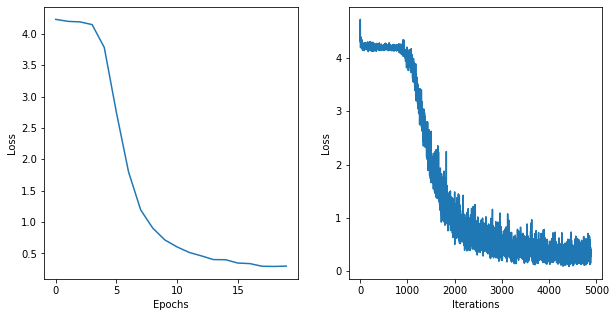

In [22]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
# loss over epoch
ax1.plot(result_loss)
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
# loss over iterations (images)
ax2.plot(iter_loss)
ax2.set_xlabel("Iterations")
ax2.set_ylabel("Loss")
plt.show()

In [23]:
results_train = pd.DataFrame(columns=['true', 'prediction'])
train_loader = DataLoader(trainset, batch_size=16, shuffle=False)
with torch.no_grad(): # skipping the gradient calculation over the weights
    for image_train, text_train  in tqdm(train_loader, leave=True):
        text_encoded = crnn(image_train.to(device)) # [T, batch_size, num_classes==num_features]
        text_decoded = decode_predictions(text_encoded.cpu()) 
        df = pd.DataFrame(columns=['true', 'prediction'])
        df['true'] = text_train
        df['prediction'] = text_decoded
        results_train = pd.concat([results_train, df])
results_train = results_train.reset_index(drop=True)
#results_train

  0%|          | 0/250 [00:00<?, ?it/s]

In [24]:
results_test = pd.DataFrame(columns=['true', 'prediction'])
test_loader = DataLoader(testset, batch_size=16, shuffle=False)
with torch.no_grad(): # skipping the gradient calculation over the weights
    for image_test, text_test  in tqdm(test_loader, leave=True):
        text_encoded = crnn(image_test.to(device)) # [T, batch_size, num_classes==num_features]
        text_decoded = decode_predictions(text_encoded.cpu())
        df = pd.DataFrame(columns=['true', 'prediction'])
        df['true'] = text_test
        df['prediction'] = text_decoded
        results_test = pd.concat([results_test, df])
results_test = results_test.reset_index(drop=True)
#results_test

  0%|          | 0/63 [00:00<?, ?it/s]

In [25]:
def remove_duplicates(text): 
    if len(text) > 1:
        letters = [text[0]] + [letter for idx, letter in enumerate(text[1:], start=1) if text[idx] != text[idx-1]]
    elif len(text) == 1:
        letters = [text[0]]
    else:
        return ""
    return "".join(letters)

def correct_prediction(word):
    parts = word.split("-") 
    parts = [remove_duplicates(part) for part in parts]
    corrected_word = "".join(parts)
    return corrected_word

# Here some prediction texts have a length not equal to 5
results_train['correct_pred'] = results_train['prediction'].apply(correct_prediction)
results_test['correct_pred'] = results_test['prediction'].apply(correct_prediction)

In [ ]:
results_train

In [28]:
results_test

,true,prediction,correct_pred
0,BPXuN,BPX-uN,BPXuN
1,edRQ7,edR-Q7,edRQ7
2,tjztM,t-jZtM,tjZtM
3,bFFyc,bFFy-C,bFyC
4,GugBE,Gug-8E,Gug8E
...,...,...,...
995,vwfjQ,vwffjQ,vwfjQ
996,kRaEJ,kRB-EJ,kRBEJ
997,ZJhcu,zJh-Cu,zJhCu
998,XzHPn,xz-HPn,xzHPn


In [26]:
train_incorrect_df = results_train[results_train['true'] != results_train['correct_pred']]
train_accuracy = 1 - train_incorrect_df.shape[0]/len(image_names_train)
train_error = 1 - train_accuracy
test_incorrect_df = results_test[results_test['true'] != results_test['correct_pred']]
test_accuracy = 1 - test_incorrect_df.shape[0]/len(image_names_test)
test_error = 1 - test_accuracy
print(f"Train accuracy {train_accuracy}")
print(f"Test accuracy {test_accuracy}")

Train accuracy 0.7085
Test accuracy 0.42200000000000004


In [ ]:
#from sklearn.metrics import confusion_matrix
#confusion_matrix(results_test[“true”], results_test[“correct_pred”])
